In [5]:
# Cell 1: Imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


2025-03-28 11:30:05.123403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 11:30:05.313610: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 11:30:05.339246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/

In [6]:
#getting image labels, sizes and batch size

TRAIN_PATH = 'veggie_heap_training'
TEST_PATH = 'veggie_heap_testing'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = sorted(os.listdir(TRAIN_PATH))  #get class names from directory

In [7]:
#augmenting the image data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
#training data generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42 #seed for ensuring same picking
)

#testing data generator
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 9835 images belonging to 12 classes.
Found 2424 images belonging to 12 classes.


In [9]:
#model architecture
model = models.Sequential([
    layers.Conv2D(64, (5,5), activation='relu', padding='same', 
                 input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu', padding='same'), #convolutional layer
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.35),
    
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(512, activation='relu', 
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(CLASS_NAMES), activation='softmax') #relu for the hidden layers, softmax for the output
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 74, 74, 128)      5

2025-03-28 11:30:09.356318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2025-03-28 11:30:09.356493: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-28 11:30:09.356513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pratham-Yoga-Slim-7-14IMH9): /proc/driver/nvidia/version does not exist
2025-03-28 11:30:09.357245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other 

In [10]:
#calling functions to train the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7,
    restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10, # 10 epochs
    validation_data=test_generator,
    callbacks=[early_stop]
)


Epoch 1/10
308/308 [==============================] - 761s 2s/step - loss: 1.3284 - accuracy: 0.6449 - val_loss: 4.8712 - val_accuracy: 0.1943
Epoch 2/10
308/308 [==============================] - 758s 2s/step - loss: 0.8795 - accuracy: 0.7705 - val_loss: 12.9024 - val_accuracy: 0.1613
Epoch 3/10
308/308 [==============================] - 761s 2s/step - loss: 0.6931 - accuracy: 0.8239 - val_loss: 7.5970 - val_accuracy: 0.3127
Epoch 4/10
308/308 [==============================] - 767s 2s/step - loss: 0.5606 - accuracy: 0.8642 - val_loss: 9.5825 - val_accuracy: 0.3729
Epoch 5/10
308/308 [==============================] - 772s 3s/step - loss: 0.4681 - accuracy: 0.8890 - val_loss: 4.6168 - val_accuracy: 0.4163
Epoch 6/10
308/308 [==============================] - 3017s 10s/step - loss: 0.4238 - accuracy: 0.9001 - val_loss: 6.4058 - val_accuracy: 0.4443
Epoch 7/10
308/308 [==============================] - 913s 3s/step - loss: 0.3899 - accuracy: 0.9064 - val_loss: 5.1471 - val_accuracy: 0.4

In [ ]:
def plot_results(history):
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train accuracy') #plots training and val accuracy v/s epoch
    plt.plot(history.history['val_accuracy'], label='val Accuracy')
    plt.title('accuracy Curves')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train Loss') #plots training and val loss v/s epoch
    plt.plot(history.history['val_loss'], label='val Loss')
    plt.title('loss Curves')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model():
    y_true = test_generator.classes
    y_pred = model.predict(test_generator) #predicted y values per the model
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', #confusion matrix
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

def plot_predictions(num_images=9):
    plt.figure(figsize=(15, 15))
    images, labels = next(test_generator)
    preds = model.predict(images)
    
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        true_label = CLASS_NAMES[np.argmax(labels[i])]
        pred_label = CLASS_NAMES[np.argmax(preds[i])]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


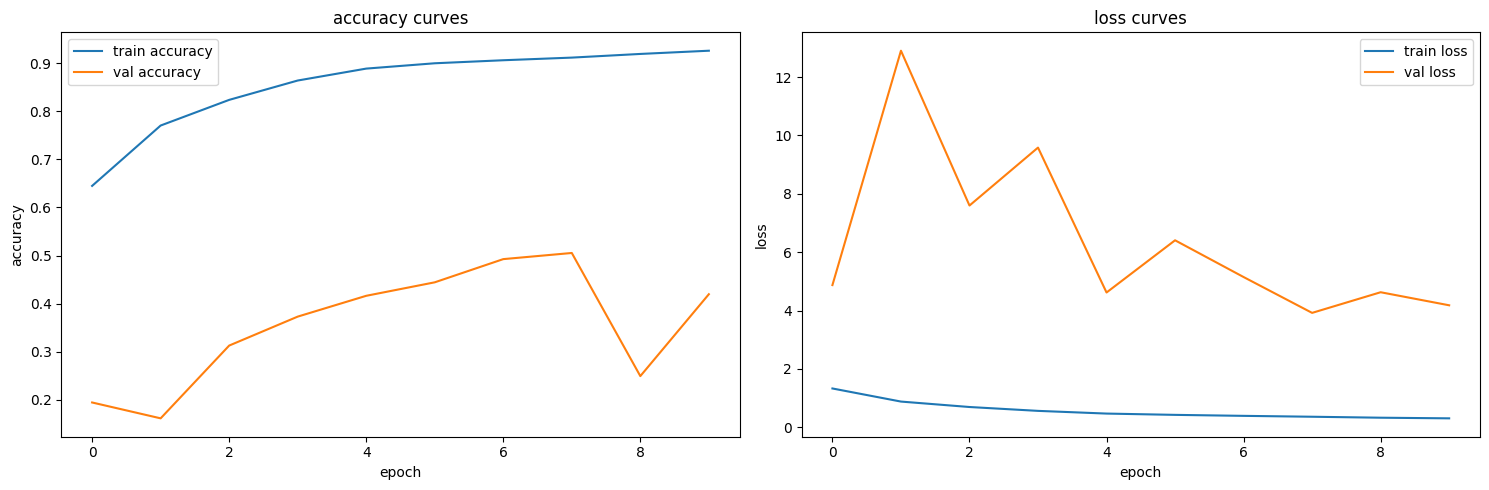

In [26]:
plot_results(history)

76/76 [==============================] - 35s 455ms/step


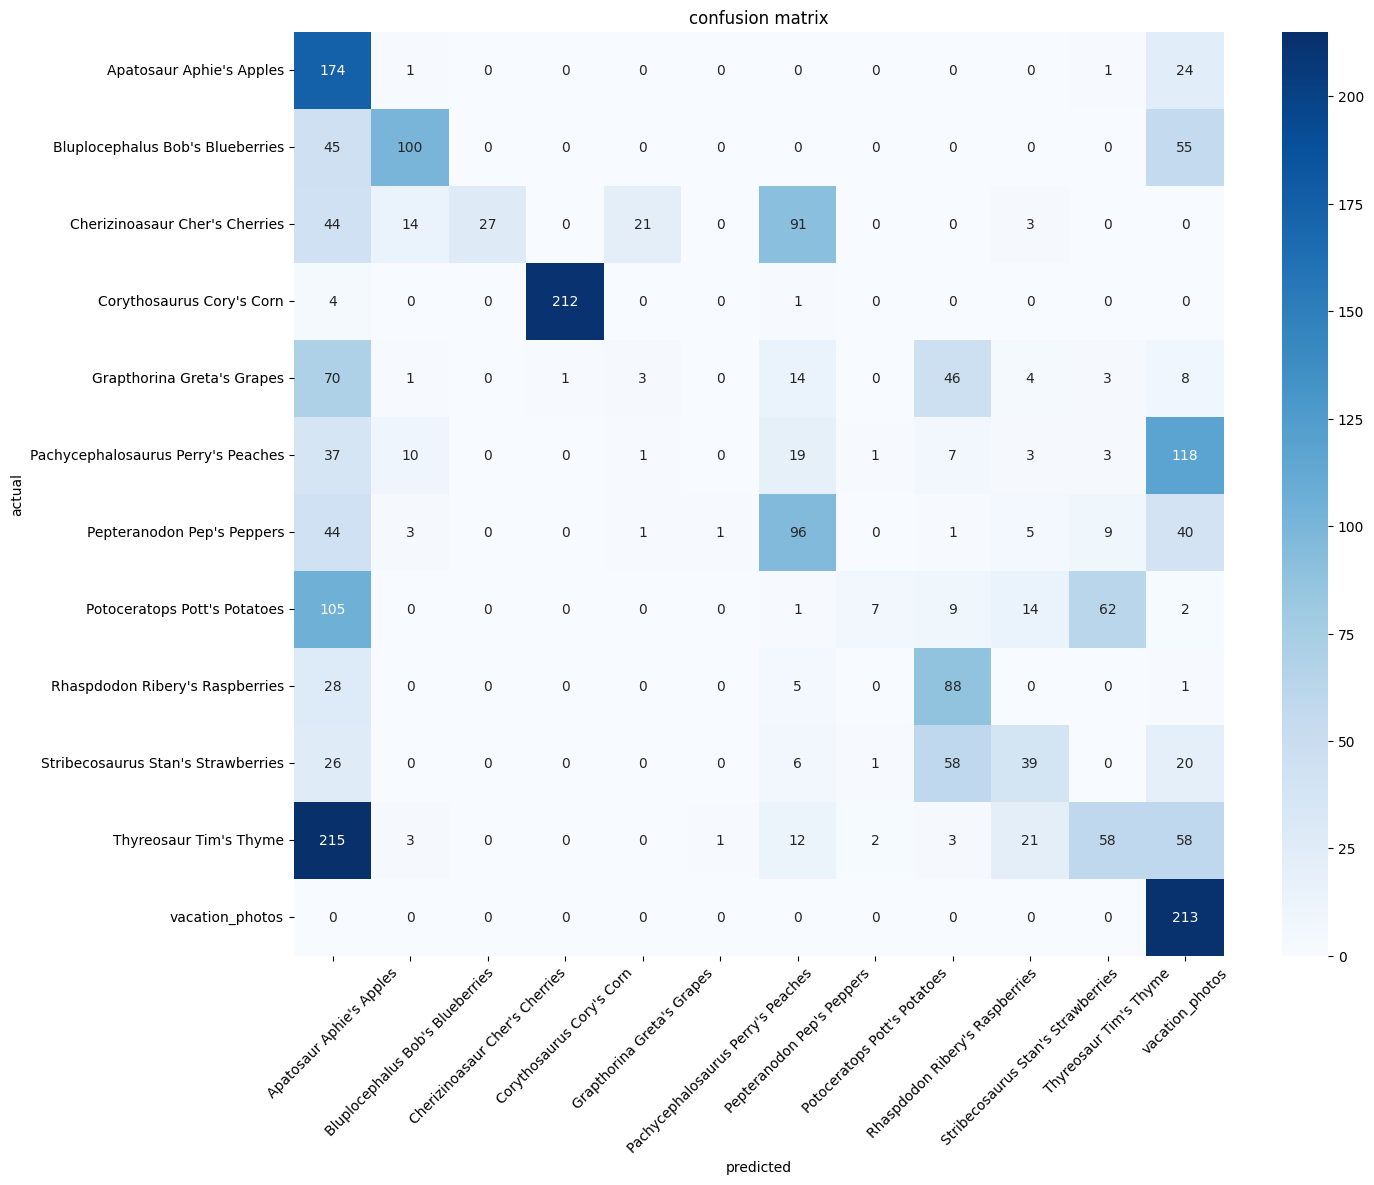

                                    precision    recall  f1-score   support

          Apatosaur Aphie's Apples       0.22      0.87      0.35       200
  Bluplocephalus Bob's Blueberries       0.76      0.50      0.60       200
    Cherizinoasaur Cher's Cherries       1.00      0.14      0.24       200
         Corythosaurus Cory's Corn       1.00      0.98      0.99       217
        Grapthorina Greta's Grapes       0.12      0.02      0.03       150
Pachycephalosaurus Perry's Peaches       0.00      0.00      0.00       199
        Pepteranodon Pep's Peppers       0.39      0.48      0.43       200
      Potoceratops Pott's Potatoes       0.64      0.04      0.07       200
   Rhaspdodon Ribery's Raspberries       0.42      0.72      0.53       122
Stribecosaurus Stan's Strawberries       0.44      0.26      0.33       150
            Thyreosaur Tim's Thyme       0.43      0.16      0.23       373
                   vacation_photos       0.40      1.00      0.57       213

          

In [27]:
evaluate_model()

1/1 [==============================] - 0s 402ms/step


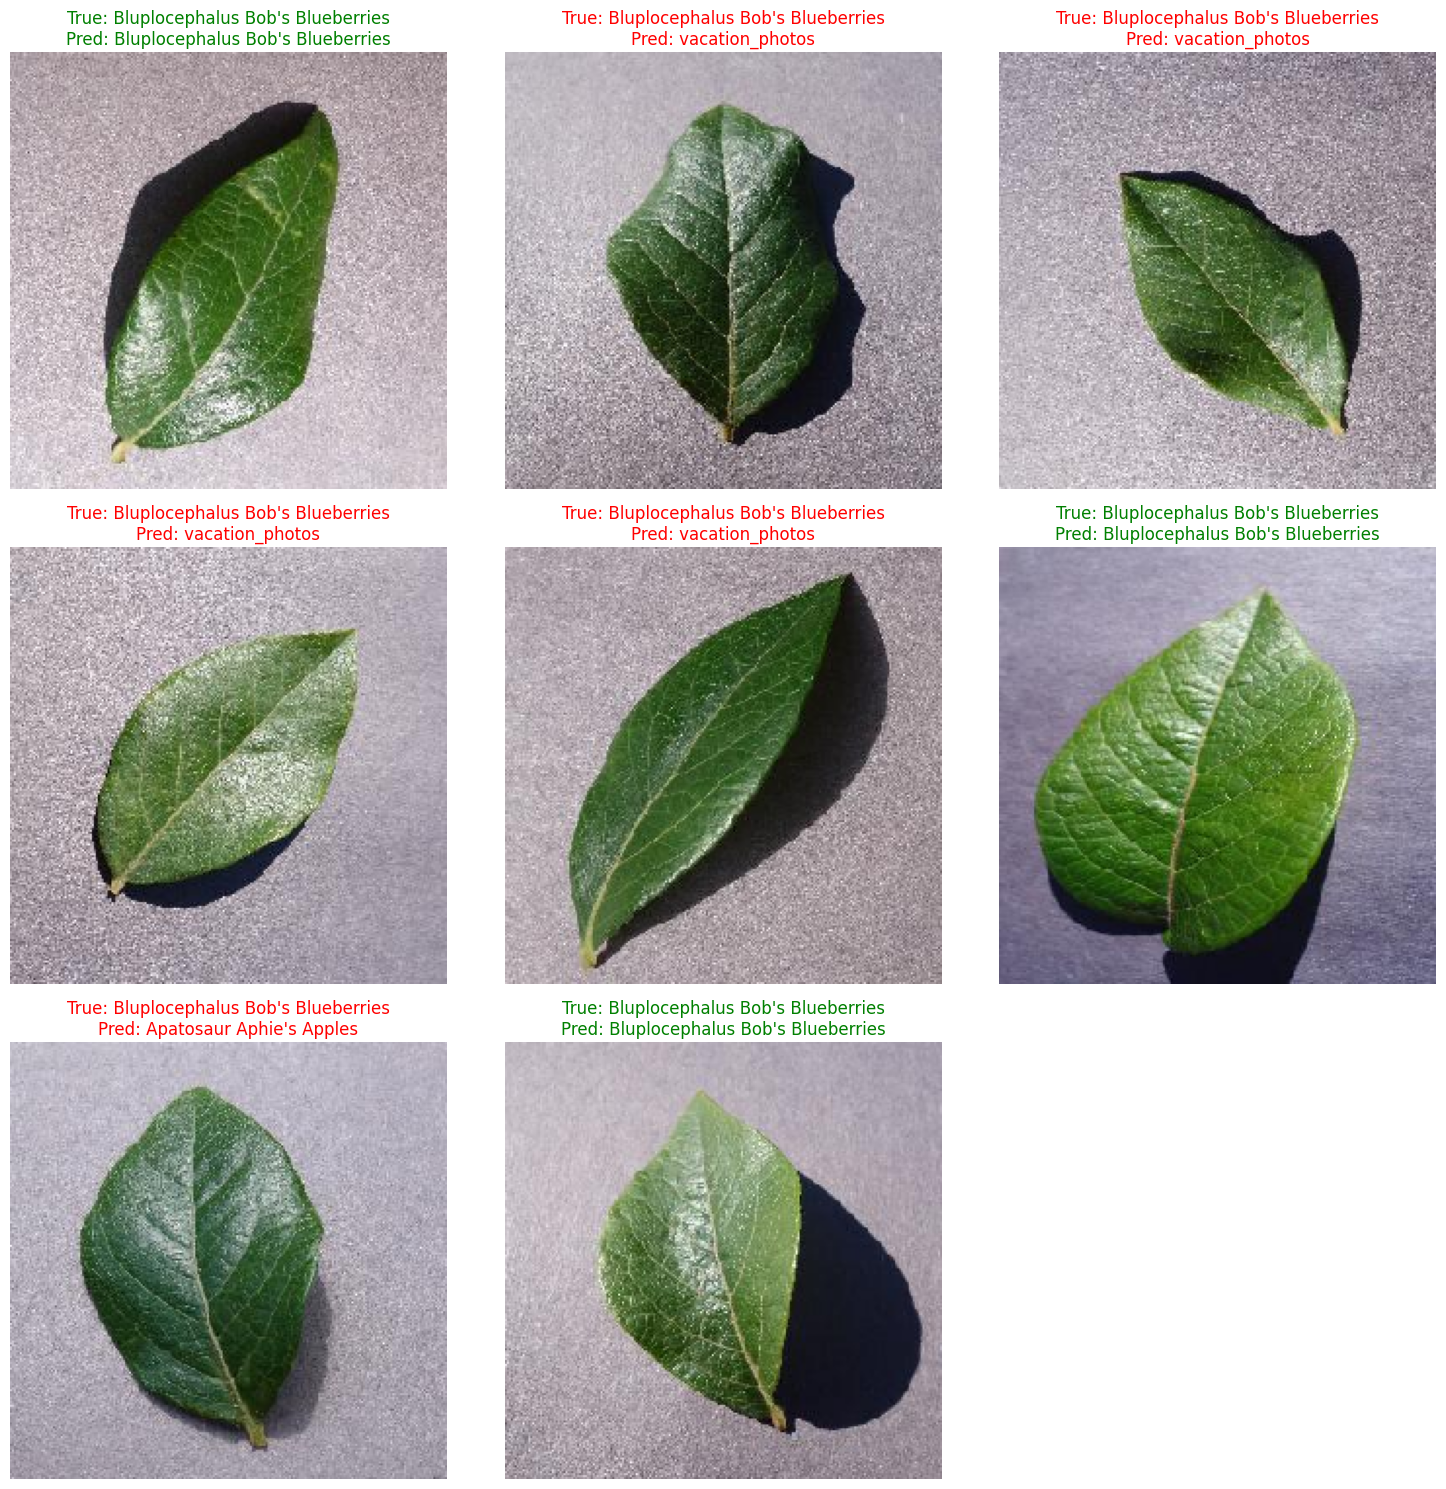

In [29]:
plot_predictions(8)